In [1]:
import os
import sys
import pandas as pd
import argparse 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [43]:
def compute_t_tpm(df, full=False):
    counts_cols = [col for col in df.columns if 'sam' in col]
    df['total_counts'] = df[counts_cols].sum(axis=1)
    total_reads = df['total_counts'].sum()
    df['tpm'] = (df.total_counts*1000000)/total_reads

    df = df[['transcript_ID', 'tpm']]

    if full:
        df.rename({'tpm': 'ab_tpm'}, axis=1, inplace=True)

    return df

def compute_g_tpm(df, full=False):
    counts_cols = [col for col in df.columns if 'sam' in col]
    df['counts'] = df[counts_cols].sum(axis=1)
    counts_cols = counts_cols+['transcript_ID', 'transcript_novelty']
    df.drop(counts_cols, axis=1, inplace=True)

    # gene groupby
    gb_cols = ['gene_ID', 'gene_novelty']
    df = df.groupby(gb_cols)['counts'].agg('sum').to_frame()
    df.reset_index(inplace=True)

    total_count = df.counts.sum()
    df['tpm'] = (df.counts*1000000)/total_count

    df = df[['gene_ID', 'tpm']]

    if full:
        df.rename({'tpm': 'ab_tpm'}, axis=1, inplace=True)

    return df

def filter(f_type, g_or_t, df):
    if g_or_t == 'gene':
        df = df.loc[df.gene_novelty == 'Known']
    elif g_or_t == 'transcript':
        if f_type == 'known':
            df = df.loc[df.transcript_novelty == 'Known']
        elif f_type == 'talon':
            df = df.loc[df.transcript_novelty.isin(['Known', 'NNC', 'NIC'])]
    return df

def get_read_num(elem):
    try:
        n = int(elem.split('_')[2])
    except:
        n = 8000000
    return n

In [44]:
def main(indir, prefix, f_type, maxfile):
    # get max reads
    with open(maxfile, 'r') as beep:
        for line in beep:
            max_reads = int(line.strip())
            max_reads = int(max_reads/2)

    # get each sam file in the input dir
    filt_files = []
    for file in glob.glob(indir+'*filtered.tsv'):
        filt_files.append(file)
    filt_files.sort(key=get_read_num)

    # get each sam file in the input dir
    ufilt_files = []
    for file in glob.glob(indir+'*abundance.tsv'):
        ufilt_files.append(file)
    ufilt_files.sort(key=get_read_num)

    # parse out the read numbers from each thing
    read_nums = [int(i.split('_')[2]) for i in filt_files[:-1]]
    read_nums.append('full')

    # load the full abundance files to compute ground-truth TPM vals
    g_df = pd.read_csv(ufilt_files[-1], sep='\t', usecols=[0,1,8,9,11,12])
    t_df = pd.read_csv(filt_files[-1], sep='\t', usecols=[0,1,8,9,11,12])

    # filter things according to whichever filter we've decided on
    g_df = filter(f_type, 'gene', g_df)
    t_df = filter(f_type, 'transcript', t_df)

    # compute tpms
    g_df = compute_g_tpm(g_df, full=True)
    t_df = compute_t_tpm(t_df, full=True)
    
    print(g_df.head())
    print(t_df.head())

    # plot de plot
    plot_df = gene(g_df, ufilt_files, read_nums, f_type, max_reads, prefix)
    summary_plot(plot_df, prefix, 1000000, kind='gene')
    summary_plot2(plot_df, prefix, 1000000, kind='gene')
    
    plot_df = transcript(t_df, filt_files, read_nums, f_type, max_reads, prefix)
    summary_plot(plot_df, prefix, 1000000, kind='transcript')
    summary_plot2(plot_df, prefix, 1000000, kind='transcript')
    return plot_df

In [65]:
def summary_plot(plot_df, prefix, depth=1000000, kind='gene'):
    temp = plot_df.loc[plot_df.reads == depth]
    order = []
    for b in sorted(temp.bin.unique().tolist()):
        order.append(temp.loc[temp.bin==b, 'TPM bin'].values[0])
    ax = sns.boxplot(data=temp, x='TPM bin', y='perc_tpm_diff', order=order, fliersize=1, saturation=1)
    plt.xticks(rotation=90)
    plt.tight_layout()
    ax.set(xlabel='', ylabel='Total TPM - Subsampled TPM as % of Full TPM', title='', ylim=(-110,110))

    fname = prefix+'_{}_{}_violin.pdf'.format(kind, depth)
    plt.savefig(fname)
    fname = prefix+'_{}_{}_violin.png'.format(kind, depth)
    plt.savefig(fname)
    plt.show()
    plt.clf()

In [71]:
def summary_plot2(plot_df, prefix, depth=1000000, kind='gene'):
    temp = plot_df.loc[plot_df.reads == depth]
    order = []
    for b in sorted(temp.bin.unique().tolist()):
        order.append(temp.loc[temp.bin==b, 'TPM bin'].values[0])
    ax = sns.boxplot(data=temp, x='TPM bin', y='tpm_diff', order=order, fliersize=1, saturation=1)
    plt.xticks(rotation=90)
    plt.tight_layout()
    print(temp.tpm_diff.max())
    print(temp.loc[temp.tpm_diff == temp.tpm_diff.max()])
    print(temp.tpm_diff.min())
    print(temp.loc[temp.tpm_diff == temp.tpm_diff.min()])
    ax.set(xlabel='', ylabel='Total TPM - Subsampled TPM', title='', ylim=(-300,210))

    fname = prefix+'_{}_{}_diff_violin.pdf'.format(kind, depth)
    plt.savefig(fname)
    fname = prefix+'_{}_{}_diff_violin.png'.format(kind, depth)
    plt.savefig(fname)
    plt.show()
    plt.clf()

In [72]:
def gene(ab, ufilt_files, read_nums, f_type, max_reads, prefix):
    # bin transcripts by expression level. How many transcripts belong to each bin?
    # assign each transcript a bin based on its expression level as well
    # bins = [(0,1),(1,2),(2,5),(5,10),(10,50),(50,100),(100,500),(500,ab.ab_tpm.max())]
    bins = [5,10,50,100,500,ab.ab_tpm.max()+1]
    ab_tpm = ab.ab_tpm.values.tolist()
    ab_bins = np.digitize(ab_tpm, bins)
    ab['bin'] = ab_bins
    ab['bin_total'] = ab['bin'].map(ab['bin'].value_counts())

    # remove entries from bin 0
    ab = ab.loc[ab.bin != 0]

    # create a bin df to keep track of how many transcripts belong to each bin
    bin_df = ab[['bin', 'bin_total']].groupby(['bin', 'bin_total']).count()
    bin_df.reset_index(inplace=True)
    
    print(bin_df)

    # loop through each interval and analyze subsampled data
    plot_data = pd.DataFrame(columns=['reads','bin','tpm_diff'])
    for fname,n in zip(ufilt_files, read_nums):

        # grab abundances, filter transcripts, and compute TPM
        sub_df = pd.read_csv(fname,sep='\t',usecols=[0,1,8,9,11,12])
        sub_df = filter(f_type, 'gene', sub_df)
        sub_df = compute_g_tpm(sub_df)

        # merge with full and determine if each gene is within 10%
        # of tpm val calculated with all reads
        sub_df = sub_df.merge(ab, how='right', on='gene_ID').fillna(0)
        sub_df['tpm_diff'] = sub_df.ab_tpm-sub_df.tpm
        sub_df['perc_tpm_diff'] = (sub_df.tpm_diff/sub_df.ab_tpm)*100

#         # set up some more metadata for plotting purposes
        if n == 'full':
            sub_df['reads'] = max_reads
        else:
            sub_df['reads'] = n
        plot_data = pd.concat([plot_data,sub_df[['gene_ID', 'reads','bin','tpm', 'ab_tpm','tpm_diff', 'perc_tpm_diff']]])
                              
#     # convert to human-readable TPM values
    plot_data = plot_data.merge(bin_df, on='bin')
    print(plot_data.bin_total.unique())
    plot_data['TPM bin'] = plot_data.apply(lambda x:
        '{}-{} TPM n={}'.format(bins[x.bin-1],bins[x.bin],x.bin_total) if bins[x.bin-1] != 500 else '{}+ TPM n={}'.format(bins[x.bin-1], x.bin_total),
#         '{}-{} TPM'.format(bins[x.bin-1],bins[x.bin]) if bins[x.bin-1] != 500 else '{}+ TPM'.format(bins[x.bin-1]),                                   
                                           
        axis=1)
    
    sns.set(rc={'figure.figsize':(7,7)})
    sns.set_context('paper', font_scale=1.5)
    sns.set_style(style='white') 
    fig = plt.figure()

    # loop through the different tpm bins
    plot_df = plot_data
#     print(plot_df.loc[plot_df.perc_tpm_diff == plot_df.perc_tpm_diff.min()])
#     print(plot_df.loc[plot_df.perc_tpm_diff == plot_df.perc_tpm_diff.max()])
    
    bins = sorted(plot_df.bin.unique().tolist())
    for i,b in enumerate(bins):

        subplot_num = i+1
        fig.add_subplot(5,1,subplot_num)
        temp = plot_df.loc[plot_df.bin==b]

        ax = sns.boxplot(data=temp, x='reads', y='perc_tpm_diff', fliersize=1, saturation=1)
        ax.set(xlabel='', ylabel='', title=temp['TPM bin'].tolist()[0])
        ax.set(xlabel='', ylabel='', title=temp['TPM bin'].tolist()[0], ylim=(-150,110))
        if b == max(bins): 
            xticks = ['{:.2f}'.format(float(interval.get_text())/1000000) for interval in ax.get_xticklabels()]
            ax.set_xticklabels(xticks)
            ax.set(xlabel='Mapped reads (millions)')     
        else: 
            ax.set_xticklabels('')
#         if i == 0:
#             ax.set_title('Difference between final and subsampled TPM calculations per gene')
    fname = prefix+'_gene_violin.pdf'
    plt.savefig(fname)
    fname = prefix+'_gene_violin.png'
    plt.savefig(fname)
    plt.clf()
    
    return plot_df

In [73]:
def transcript(ab, filt_files, read_nums, f_type, max_reads, prefix):

    # bin transcripts by expression level. How many transcripts belong to each bin?
    # assign each transcript a bin based on its expression level as well
    # bins = [(0,1),(1,2),(2,5),(5,10),(10,50),(50,100),(100,500),(500,ab.ab_tpm.max())]
    bins = [5,10,50,100,500,ab.ab_tpm.max()+1]
    ab_tpm = ab.ab_tpm.values.tolist()
    ab_bins = np.digitize(ab_tpm, bins)
    ab['bin'] = ab_bins
    ab['bin_total'] = ab['bin'].map(ab['bin'].value_counts())

    # remove entries from bin 0
    ab = ab.loc[ab.bin != 0]

    # create a bin df to keep track of how many transcripts belong to each bin
    bin_df = ab[['bin', 'bin_total']].groupby(['bin', 'bin_total']).count()
    bin_df.reset_index(inplace=True)

    # loop through each interval and analyze subsampled data
    plot_data = pd.DataFrame(columns=['reads','bin','tpm_diff'])
    for fname,n in zip(filt_files, read_nums):

        # grab abundances, filter transcripts, and compute TPM
        sub_df = pd.read_csv(fname,sep='\t',usecols=[0,1,8,9,11,12])
        sub_df = filter(f_type, 'transcript', sub_df)
        sub_df = compute_t_tpm(sub_df)

        # merge with full 
        sub_df = sub_df.merge(ab, how='right', on='transcript_ID').fillna(0)
        sub_df['tpm_diff'] = sub_df.ab_tpm-sub_df.tpm
        sub_df['perc_tpm_diff'] = (sub_df.tpm_diff/sub_df.ab_tpm)*100

#         # set up some more metadata for plotting purposes
        if n == 'full':
            sub_df['reads'] = max_reads
        else:
            sub_df['reads'] = n
        plot_data = pd.concat([plot_data,sub_df[['transcript_ID', 'reads','bin','tpm', 'ab_tpm','tpm_diff', 'perc_tpm_diff']]])
#     print(sub_df.columns)
                              
#     # convert to human-readable TPM values
    plot_data = plot_data.merge(bin_df, on='bin')
#     print(plot_data.bin_total.unique())
    plot_data['TPM bin'] = plot_data.apply(lambda x:
        '{}-{} TPM n={}'.format(bins[x.bin-1],bins[x.bin],x.bin_total) if bins[x.bin-1] != 500 else '{}+ TPM n={}'.format(bins[x.bin-1], x.bin_total),
#         '{}-{} TPM'.format(bins[x.bin-1],bins[x.bin]) if bins[x.bin-1] != 500 else '{}+ TPM'.format(bins[x.bin-1]),                                   
        axis=1)
    
    sns.set(rc={'figure.figsize':(7,7)})
    sns.set_context('paper', font_scale=1.5)
    sns.set_style(style='white') 
    fig = plt.figure()

    # loop through the different tpm bins
    plot_df = plot_data
    bins = sorted(plot_df.bin.unique().tolist())
    for i,b in enumerate(bins):

        subplot_num = i+1
        fig.add_subplot(5,1,subplot_num)
        temp = plot_df.loc[plot_df.bin==b]

        ax = sns.boxplot(data=temp, x='reads', y='perc_tpm_diff', fliersize=1, saturation=1)
        ax.set(xlabel='', ylabel='', title=temp['TPM bin'].tolist()[0])
        ax.set(xlabel='', ylabel='', title=temp['TPM bin'].tolist()[0], ylim=(-150,110))
        if b == max(bins): 
            xticks = ['{:.2f}'.format(float(interval.get_text())/1000000) for interval in ax.get_xticklabels()]
            ax.set_xticklabels(xticks)
            ax.set(xlabel='Mapped reads (millions)')     
        else: 
            ax.set_xticklabels('')
#         if i == 0:
#             ax.set_title('Difference between final and subsampled TPM calculations per transcript')
    fname = prefix+'_transcript_violin.pdf'
    plt.savefig(fname)
    fname = prefix+'_transcript_violin.png'
    plt.savefig(fname)
    plt.clf()
    plt.show()
    
    return plot_df
    

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


   gene_ID    ab_tpm
0        2  0.239709
1       10  0.239709
2       16  0.479418
3       19  0.239709
4       20  1.198545
   transcript_ID    ab_tpm
0             32  0.306000
1             93  0.612000
2             99  0.306000
3            124  0.306000
4            136  3.060002
   bin  bin_total
0    1       1778
1    2       3654
2    3       1269
3    4       1473
4    5        325
[1778 1269 1473 3654  325]


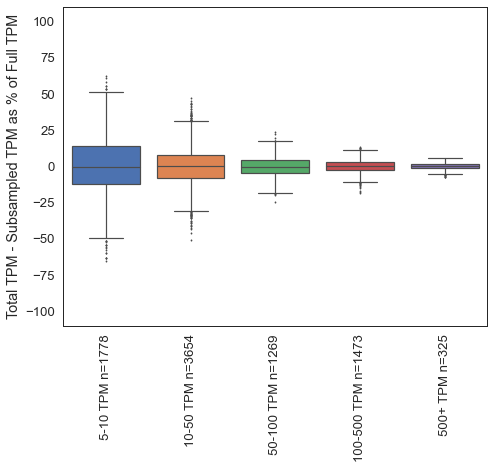

127.38047038933837
         reads bin   tpm_diff  gene_ID           tpm        ab_tpm  \
74856  1000000   5  127.38047  55890.0  13047.748086  13175.128556   

       perc_tpm_diff  bin_total         TPM bin  
74856       0.966825        325  500+ TPM n=325  
-239.66607682643553
         reads bin    tpm_diff  gene_ID           tpm        ab_tpm  \
74749  1000000   5 -239.666077  34838.0  10947.709083  10708.043006   

       perc_tpm_diff  bin_total         TPM bin  
74749      -2.238187        325  500+ TPM n=325  


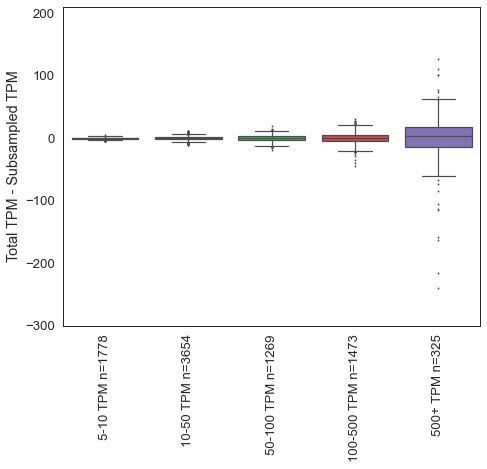

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

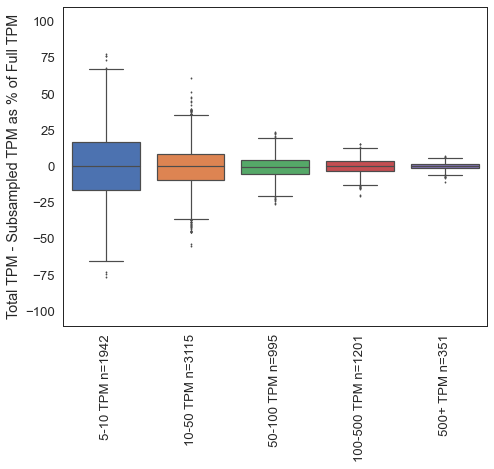

175.99241580054877
         reads bin    tpm_diff  transcript_ID           tpm        ab_tpm  \
66670  1000000   5  175.992416       199688.0  16100.156829  16276.149245   

       perc_tpm_diff  bin_total         TPM bin  
66670        1.08129        351  500+ TPM n=351  
-301.23072739616146
         reads bin    tpm_diff  transcript_ID           tpm        ab_tpm  \
66549  1000000   5 -301.230727       121389.0  13630.904299  13329.673571   

       perc_tpm_diff  bin_total         TPM bin  
66549      -2.259851        351  500+ TPM n=351  


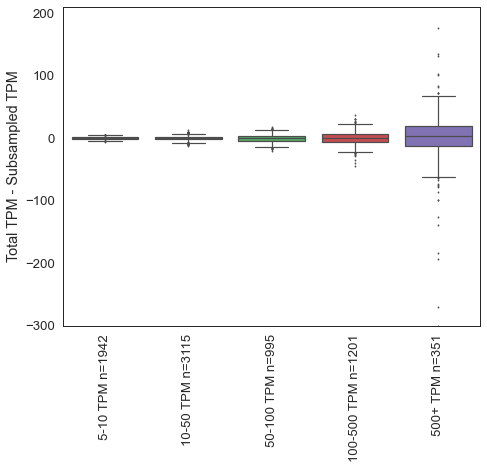

<Figure size 504x504 with 0 Axes>

In [74]:
# PacBio known genes and transcripts

indir = 'pb_talon/'
prefix = 'figures/pacbio_known'
f_type = 'known'
maxfile = 'pb_talon/pb_talon_max_reads'

df = main(indir, prefix, f_type, maxfile)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


   gene_ID     ab_tpm
0        2   7.394439
1        3   0.352116
2       13   3.169045
3       20  22.183317
4       22   0.352116
   transcript_ID    ab_tpm
0              4  0.687818
1             22  3.439092
2             32  9.629458
3             91  1.375637
4             92  6.878185
   bin  bin_total
0    1       1887
1    2       4896
2    3       1444
3    4       1211
4    5        242
[1887 4896 1444 1211  242]


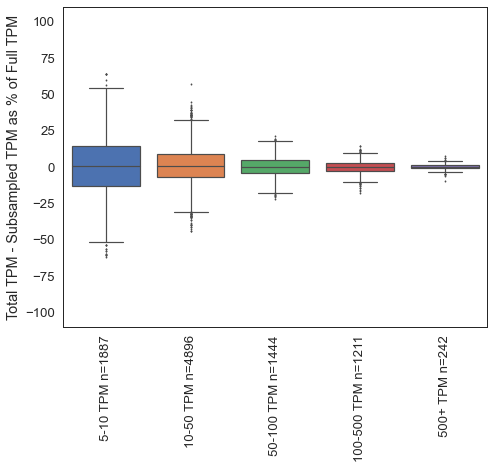

108.55980153652308
         reads bin    tpm_diff  gene_ID           tpm        ab_tpm  \
67021  1000000   5  108.559802  55890.0  15616.595235  15725.155037   

       perc_tpm_diff  bin_total         TPM bin  
67021       0.690358        242  500+ TPM n=242  
-80.84544360739619
         reads bin   tpm_diff  gene_ID          tpm       ab_tpm  \
67001  1000000   5 -80.845444  51456.0  5006.950349  4926.104905   

       perc_tpm_diff  bin_total         TPM bin  
67001      -1.641164        242  500+ TPM n=242  


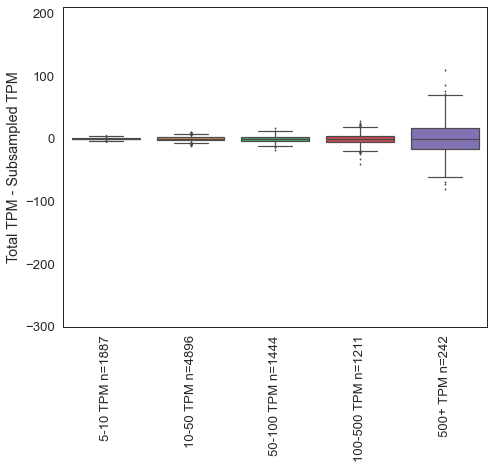

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

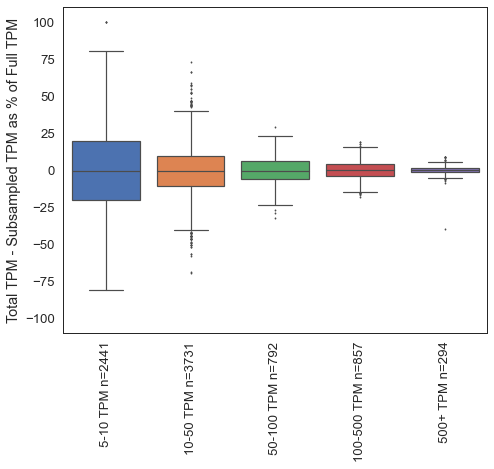

198.817875660945
         reads bin    tpm_diff  transcript_ID           tpm        ab_tpm  \
23786  1000000   5  198.817876       199688.0  22958.654034  23157.471909   

       perc_tpm_diff  bin_total         TPM bin  
23786       0.858547        294  500+ TPM n=294  
-1193.7991376316954
         reads bin     tpm_diff  transcript_ID          tpm       ab_tpm  \
23698  1000000   5 -1193.799138       146193.0  4187.185075  2993.385938   

       perc_tpm_diff  bin_total         TPM bin  
23698      -39.88123        294  500+ TPM n=294  


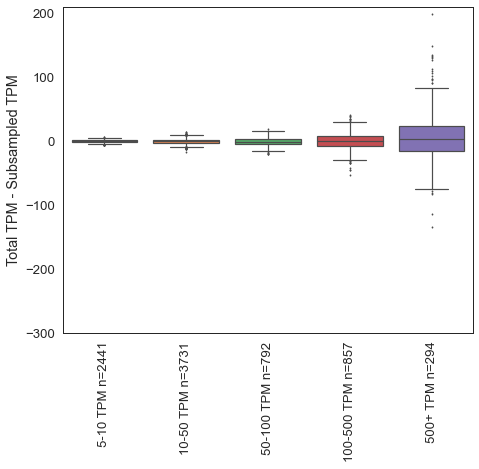

<Figure size 504x504 with 0 Axes>

In [75]:
# ONT known genes and transcripts

indir = 'ont_talon/'
prefix = 'figures/ont_known'
f_type = 'known'
maxfile = 'ont_talon/ont_talon_max_reads'

df = main(indir, prefix, f_type, maxfile)